# Directionality charts

Here I attempt to make polar bar charts/histograms for different gpx routes, to display how much they go "in the right direction".


In [80]:
import gpxpy
import matplotlib.pyplot as plt
import numpy


Let's make constants for the routes we want to work with


In [81]:
BHM_TO_STR = "../data/bike/BHM_TO_STR.gpx"
BIC_TO_BED = "../data/bike/BIC_TO_BED.gpx"
BED_TO_SAN = "../data/bike/BED_TO_SAN.gpx"
BIKE_ROUTES = [BHM_TO_STR, BIC_TO_BED, BED_TO_SAN]

MAIN_ROUTE = "../data/cycle.travel/BHM_TO_CAM.gpx"

BIRMINGHAM_COORDS = (-1.9018053, 52.4765926)
CAMBRIDGE_COORDS = (0.1297757, 52.2149504)


Next, functions to load data and display it easily


In [82]:
def get_xy_from_gpx(gpx_filename: str):
    gpx_file = open(gpx_filename, 'r')
    gpx = gpxpy.parse(gpx_file)
    x = []
    y = []
    for track in gpx.tracks:
        for segment in track.segments:
            for point in segment.points:
                x.append(point.longitude)
                y.append(point.latitude)
    return x, y


Now let's show the bike route vs proposed bike route.


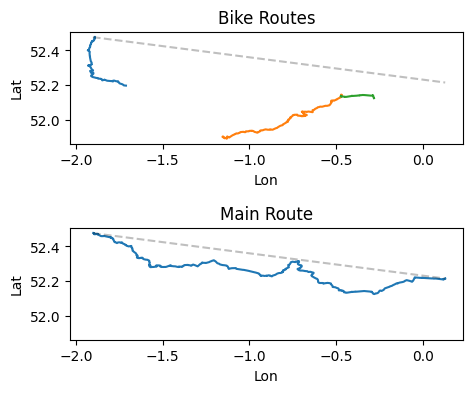

In [86]:

done_coords_1 = get_xy_from_gpx(BHM_TO_STR)
done_coords_2 = get_xy_from_gpx(BIC_TO_BED)
done_coords_3 = get_xy_from_gpx(BED_TO_SAN)

proposed_coords = get_xy_from_gpx(MAIN_ROUTE)

fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212, sharex=ax1, sharey=ax1)

ax1.plot(done_coords_1[0], done_coords_1[1])
ax1.plot(done_coords_2[0], done_coords_2[1])
ax1.plot(done_coords_3[0], done_coords_3[1])
ax2.plot(proposed_coords[0], proposed_coords[1])

for ax in ax1, ax2:
    ax.set_ylabel('Lat')
    ax.set_xlabel('Lon')
    ax.plot([BIRMINGHAM_COORDS[0], CAMBRIDGE_COORDS[0]],
            [BIRMINGHAM_COORDS[1], CAMBRIDGE_COORDS[1]],
            'k--', alpha=0.25)
    ax.set_aspect('equal')
ax1.set_title('Bike Routes')
ax2.set_title('Main Route')

plt.subplots_adjust(hspace=0.75)
plt.show()


Next, let's calculate the directionality of each route, and display it in a polar histogram


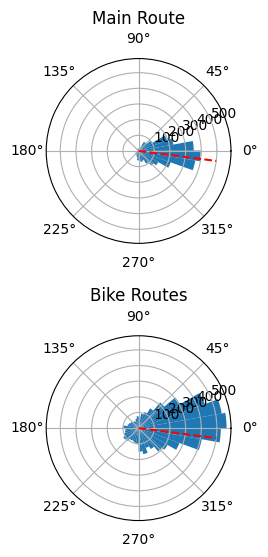

In [99]:
def direction_of(x1: float, y1: float, x2: float, y2: float):
    """Returns the direction of the line from (x1, y1) to (x2, y2) in radians
    """
    distance_x = x2 - x1
    distance_y = y2 - y1
    direction = numpy.arctan2(distance_y, distance_x)
    return direction


def directions_of(longs: list[float], lats: list[float]):
    """Returns the directions of the lines between the points in the lists.
    """
    directions = []
    for i in range(len(longs) - 1):
        directions.append(direction_of(
            longs[i], lats[i], longs[i + 1], lats[i + 1]))
    return numpy.array(directions)


def length_of(x1: float, y1: float, x2: float, y2: float):
    """Returns the length of the line from (x1, y1) to (x2, y2)
    """
    distance_x = x2 - x1
    distance_y = y2 - y1
    length = numpy.sqrt(distance_x**2 + distance_y**2)
    return length


def length_ofs(longs: list[float], lats: list[float]):
    """Returns the lengths of the lines between the points in the lists.
    """
    lengths = []
    for i in range(len(longs) - 1):
        lengths.append(length_of(
            longs[i], lats[i], longs[i + 1], lats[i + 1]))
    return numpy.array(lengths)


done_directions_1 = directions_of(*done_coords_1)
done_directions_2 = directions_of(*done_coords_2)
done_directions_3 = directions_of(*done_coords_3)
done_directions = numpy.concatenate(
    [done_directions_1, done_directions_2, done_directions_3])
proposed_directions = directions_of(*proposed_coords)

done_lengths_1 = length_ofs(*done_coords_1)
done_lengths_2 = length_ofs(*done_coords_2)
done_lengths_3 = length_ofs(*done_coords_3)
done_lengths = numpy.concatenate(
    [done_lengths_1, done_lengths_2, done_lengths_3])
proposed_lengths = length_ofs(*proposed_coords)

CAMBDIRGE_DIRECTION = direction_of(*BIRMINGHAM_COORDS, *CAMBRIDGE_COORDS)

fig = plt.figure(figsize=(6, 6))
ax1 = fig.add_subplot(211, projection='polar')
ax2 = fig.add_subplot(212, projection='polar', sharey=ax1)

for ax, directions in zip([ax1, ax2],
                          [proposed_directions, done_directions]):
    ax.vlines(CAMBDIRGE_DIRECTION, 0, 500,
              color='r', linestyle='--', alpha=0.5)
    bins, edges = numpy.histogram(directions, bins=36)
    ax.bar(edges[:-1], bins, width=2 * numpy.pi / 36, align='edge')

ax1.set_title('Main Route')
ax2.set_title('Bike Routes')

plt.subplots_adjust(hspace=0.5)
plt.show()
